I'll follow classification process with https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [1]:
import time
import numpy as np

import torch
from torch import nn
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

_____

In [2]:
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)
        
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [3]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True) # embedding + averaging
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)
    
class Identity(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

In [4]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

_____

In [5]:
tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(device)

# set vocab size
vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

cuda


In [6]:
# load nn.Module object
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter])); print(num_class)
vocab_size = len(vocab); print(vocab_size)
emsize = 32
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

4
95811


In [7]:
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

### generate imbalanced

____

In [8]:
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

In [9]:
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.663
| epoch   1 |  1000/ 1782 batches | accuracy    0.848
| epoch   1 |  1500/ 1782 batches | accuracy    0.878
-----------------------------------------------------------
| end of epoch   1 | time: 14.20s | valid accuracy    0.879 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.897
| epoch   2 |  1000/ 1782 batches | accuracy    0.900
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time: 13.35s | valid accuracy    0.894 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.912
| epoch   3 |  1000/ 1782 batches | accuracy    0.912
| epoch   3 |  1500/ 1782 batches | accuracy    0.918
-----------------------------------------------------------
| end of epoch   3 | time: 11.31s | valid accuracy    0.905 
-------------------------------

____

In [29]:
from cycler import cycler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [30]:
model.fc = Identity()

In [31]:
def get_all_embeddings(loader, model):
    model.eval()
    emb_container = []
    label_container = []

    for idx, (label, text, offsets) in enumerate(loader):
        emb = model(text, offsets)
        emb_container.append(emb.cpu())
        label_container.append(label.cpu())

    x,y = torch.cat(emb_container), torch.cat(label_container)
    return x.detach(), y.detach()

In [32]:
label_dict = {1 : 'World',
2 : 'Sports',
3 : 'Business',
4 : "Sci/Tec"}

In [33]:
embeddings, labels = get_all_embeddings(test_dataloader, model)

In [34]:
tsne_embeddings = TSNE(2).fit_transform(embeddings)

In [54]:
from sklearn.metrics.pairwise import cosine_similarity

In [56]:
dict_ = dict()

for l in torch.unique(labels) : 
    tmp = embeddings[labels == l].numpy()
    cs_mat = cosine_similarity(tmp)
    cs_mat[np.tril_indices_from(cs_mat)] = np.nan
    dict_[l] = np.nanmean(cs_mat)

In [57]:
dict_

{tensor(0): 0.44487965,
 tensor(1): 0.5202507,
 tensor(2): 0.38278782,
 tensor(3): 0.28439894}

In [62]:
np.mean(list(dict_.values()))

0.40807927

____

# Full visualization

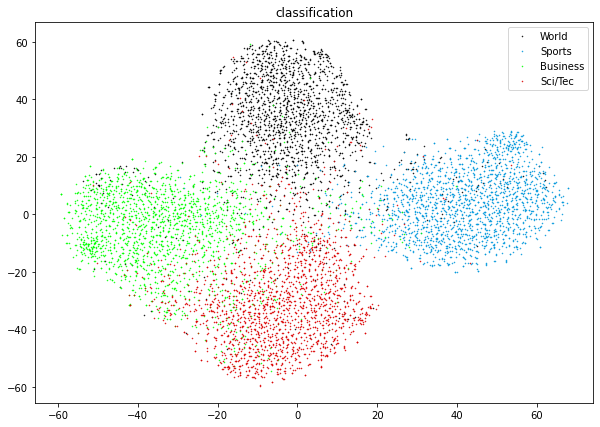

In [64]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes):
    idx = labels == label_set[i]
    str_label = label_dict[label_set[i]+1]
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=1, label=str_label)
plt.legend()
plt.title("classification")
plt.show()

# Imbalanced visualization

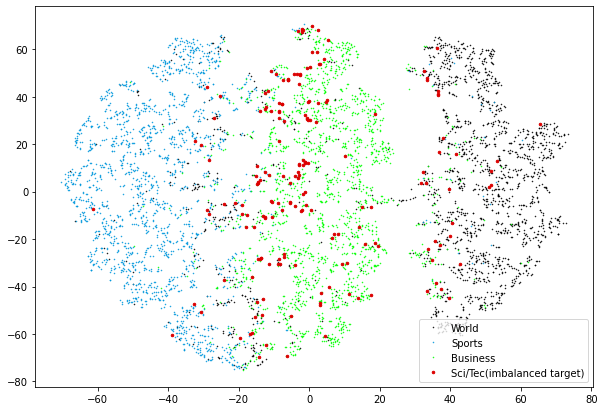

In [85]:
label_set = np.unique(labels)
num_classes = len(label_set)
fig = plt.figure(figsize=(10,7))

plt.gca().set_prop_cycle(cycler("color", [plt.cm.nipy_spectral(i) for i in np.linspace(0, 0.9, num_classes)]))
for i in range(num_classes):
    idx = labels == label_set[i]
    str_label = label_dict[label_set[i]+1]
    str_label = str_label+"(imbalanced target)" if i == 4-1 else str_label
    markersize = 5 if i == 4-1 else 1
    plt.plot(tsne_embeddings[idx, 0], tsne_embeddings[idx, 1], ".", markersize=markersize, label=str_label)
plt.legend()
plt.show()